Playing around with the tutorial at: https://docs.microsoft.com/en-us/learn/modules/intro-computer-vision-pytorch/3-train-dense-neural-networks

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, plot_results



In [2]:
load_mnist()


In [3]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax(dim = 1))

In [4]:
print('Digit to be predicted: ', data_train[0][1])
torch.exp(net(data_train[0][0]))


Digit to be predicted:  5


tensor([[0.0792, 0.1302, 0.0996, 0.0742, 0.0878, 0.1141, 0.0758, 0.1091, 0.1218,
         0.1082]], grad_fn=<ExpBackward0>)

In [5]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)
# we can use larger batch size for testing
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)


In [7]:
print('Min intensity value: ',train_set[0][0].min().item())
print('Max intensity value: ',train_set[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


In [6]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, count = 0,0,0
    for features, labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count+=len(labels)

    return total_loss.item()/count, acc.item()/count

train_epoch(net, train_loader)

(0.005934868367513021, 0.8926333333333333)

In [8]:
def validate(net, dataloader, loss_fn = nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0,0,0
    with torch.no_grad():
        for features, labels in dataloader:
            out = net(features)
            loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net, test_loader)

(0.005859263610839844, 0.8943)

In [9]:
# looking into overfitting

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


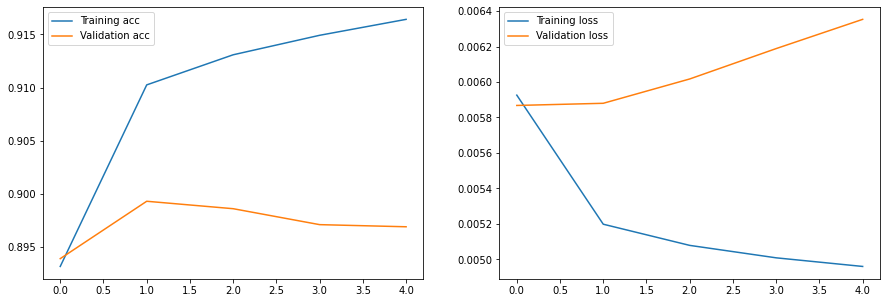

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


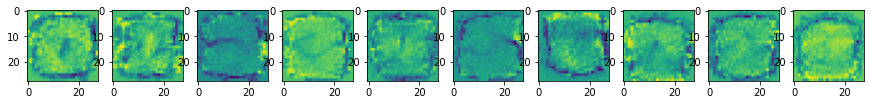

In [11]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

ReLU: if a network consists just of a series of linear layers, it would essentially be equivalent to one linear layer. 

Thus inserting non-linear functions in between layers is important!


In [12]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,100),
        nn.ReLU(),
        nn.Linear(100,10),
        nn.LogSoftmax(dim = 0))

summary(net, input_size = (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Number of parameters for linear layer: W1*x + b -> eg 1-2 has: dim(W1)=784*100. dim(b) = 100 

In [13]:
# class implementation of the network
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784, 100)
        self.out = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = relu(self.hidden(x))
        x = log_softmax(self.out(x), dim = 0)
        return x

net = MyNet()
summary(net, input_size = (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Epoch  0, Train acc=0.961, Val acc=0.954, Train loss=0.033, Val loss=0.033
Epoch  1, Train acc=0.963, Val acc=0.958, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.965, Val acc=0.956, Train loss=0.032, Val loss=0.033
Epoch  3, Train acc=0.965, Val acc=0.955, Train loss=0.032, Val loss=0.033
Epoch  4, Train acc=0.966, Val acc=0.956, Train loss=0.032, Val loss=0.033


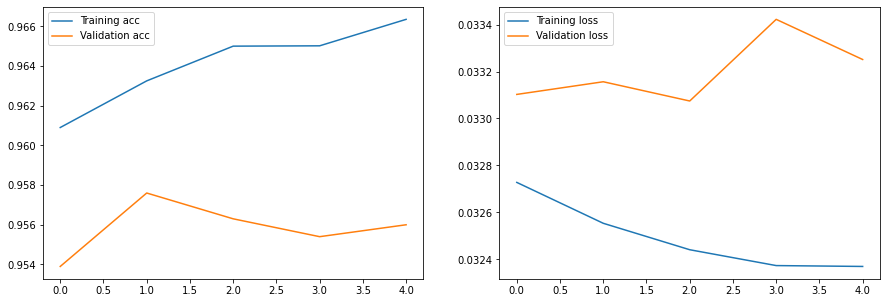

In [15]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)


CNN Part

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

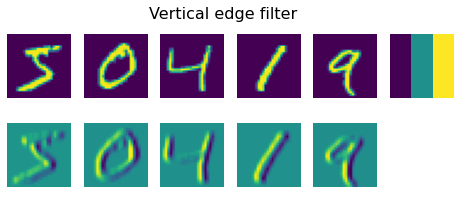

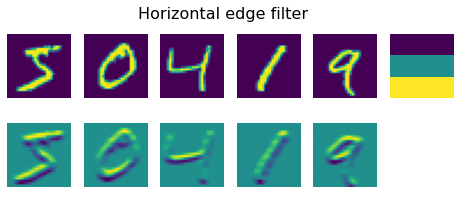

In [2]:
plot_convolution(torch.tensor(
    [[-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.]]), 'Vertical edge filter')
plot_convolution(torch.tensor(
    [[-1., -1., -1.], [0., 0., 0.], [1., 1., 1.]]), 'Horizontal edge filter')


In [5]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 9, kernel_size = (5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(9*24*24, 10) # dimension derives from 24*24 being the possible position for the filter. 9 being the number of filters

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim = 1)
        return x

net = OneConv()
summary(net, input_size = (1,1,28,28))



Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Epoch  0, Train acc=0.948, Val acc=0.970, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.978, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.985, Val acc=0.978, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.976, Train loss=0.000, Val loss=0.001


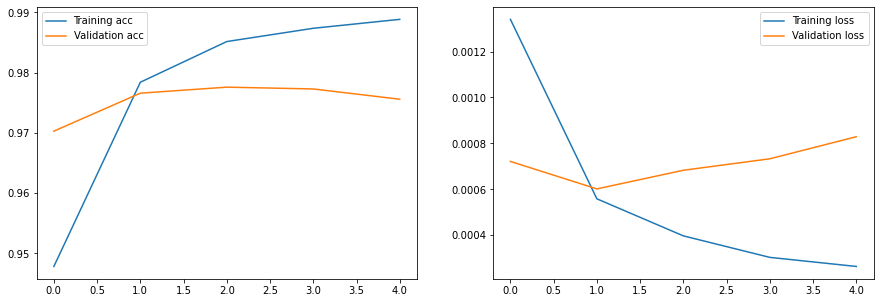

In [6]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

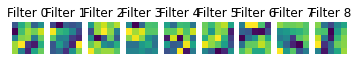

In [8]:
fig, ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.view(5,5).detach())
        ax[i].set_title(f"Filter {i}")
        ax[i].axis('off')

On to Pooling and Deeper CNNs

In [10]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x), dim = 1)
        return x

net = MultiLayerCNN()
summary(net, input_size = (1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [11]:
hist = train(net, train_loader, test_loader, epochs=5)

Epoch  0, Train acc=0.952, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.982, Val acc=0.982, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.985, Val acc=0.986, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.987, Val acc=0.984, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.987, Val acc=0.983, Train loss=0.000, Val loss=0.000


On to the CIFAR Dataset

In [12]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


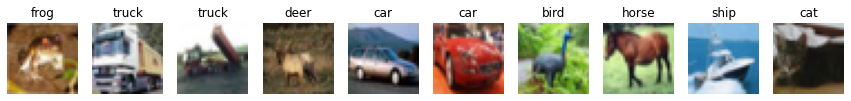

In [13]:
display_dataset(trainset, classes = classes)

In [14]:
# implementation of LeNet

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()
summary(net, input_size = (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [15]:
opt = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3,
             optimizer=opt, loss_fn=nn.CrossEntropyLoss())


Epoch  0, Train acc=0.261, Val acc=0.402, Train loss=0.142, Val loss=0.117
Epoch  1, Train acc=0.436, Val acc=0.477, Train loss=0.109, Val loss=0.104
Epoch  2, Train acc=0.503, Val acc=0.539, Train loss=0.098, Val loss=0.092


Transfer Time

In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir


In [21]:
https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

'/Users/friedrichwilkegrosche/hivemind'

In [24]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [27]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')


In [30]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')


Corrupt image: data/PetImages/Cat/666.jpg


/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image: data/PetImages/Dog/11702.jpg


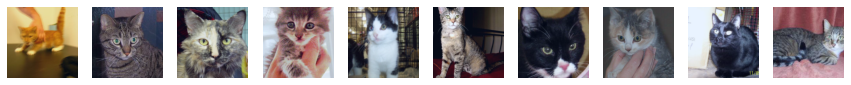

In [31]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages', transform=trans)
trainset, testset = torch.utils.data.random_split(
    dataset, [20000, len(dataset)-20000])

display_dataset(dataset)


In [32]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())


/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/friedrichwilkegrosche/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

tensor(282)


In [35]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()


Doing computations on device = cpu


tensor(282)

torch.Size([1, 512, 7, 7])


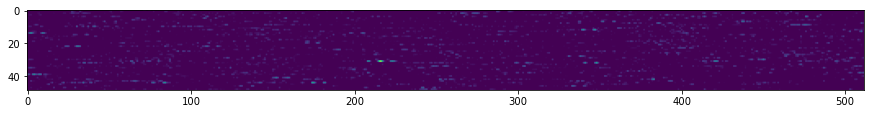

In [37]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15, 3))
plt.imshow(res.detach().view(-1, 512))
print(res.size())


In [38]:
bs = 8
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num, 512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x, l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs, -1)
        label_tensor[i:i+bs] = l
        i += bs
        print('.', end='')
        if i >= num:
            break


....................................................................................................

In [39]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.929, Val acc=0.960, Train loss=0.040, Val loss=0.035


/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  1, Train acc=0.993, Val acc=0.990, Train loss=0.005, Val loss=0.009
Epoch  2, Train acc=0.994, Val acc=0.980, Train loss=0.003, Val loss=0.012
Epoch  3, Train acc=1.000, Val acc=0.980, Train loss=0.000, Val loss=0.010
Epoch  4, Train acc=0.999, Val acc=0.970, Train loss=0.000, Val loss=0.005
Epoch  5, Train acc=0.999, Val acc=0.980, Train loss=0.000, Val loss=0.003
Epoch  6, Train acc=0.999, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  7, Train acc=0.997, Val acc=0.980, Train loss=0.001, Val loss=0.035
Epoch  8, Train acc=0.993, Val acc=0.940, Train loss=0.004, Val loss=0.166
Epoch  9, Train acc=0.996, Val acc=0.960, Train loss=0.004, Val loss=0.091


In [40]:
print(vgg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
vgg.classifier = torch.nn.Linear(25088,2).to(device) # replace the VGG classifier for 1000 classes with one that simply differentiates between cats and dogs

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [42]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.6875, train loss = 0.04460291191935539
Epoch 0, minibatch 90: train acc = 0.9560439560439561, train loss = 0.08968707493373326
Epoch 0, minibatch 180: train acc = 0.9613259668508287, train loss = 0.11082354171500021
Epoch 0, minibatch 270: train acc = 0.9649446494464945, train loss = 0.11390980935184718
Epoch 0, minibatch 360: train acc = 0.9679709141274239, train loss = 0.11579608653060618


/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 0, minibatch 450: train acc = 0.9690964523281597, train loss = 0.11814666375881289
Epoch 0, minibatch 540: train acc = 0.9693853974121996, train loss = 0.12446312190424272
Epoch 0, minibatch 630: train acc = 0.9712757527733756, train loss = 0.11912321402040411
Epoch 0, minibatch 720: train acc = 0.9726074895977809, train loss = 0.12123979840959821
Epoch 0, minibatch 810: train acc = 0.9727188655980271, train loss = 0.12639434475787029
Epoch 0, minibatch 900: train acc = 0.9739178690344062, train loss = 0.12325059930968629
Epoch 0, minibatch 990: train acc = 0.9743314833501514, train loss = 0.1237746160759334
Epoch 0, minibatch 1080: train acc = 0.9746184088806661, train loss = 0.1257782688193802
Epoch 0, minibatch 1170: train acc = 0.974434244235696, train loss = 0.13181274309817997
Epoch 0 done, validation acc = 0.978391356542617, validation loss = 0.17396752402132729


Save and Load the model to allow for later tuning.

In [43]:
torch.save(vgg,'data/cats_dogs.pth')

In [44]:
vgg = torch.load('data/cats_dogs.pth')


Allow the CNN weights to also be trained.

In [46]:
for x in vgg.features.parameters():
    x.requires_grad = True


Train the CNN weights

In [ ]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

In [49]:
# other models
resnet = torchvision.models.resnet18()
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Mobile Net

In [50]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import os

from pytorchcv import train, plot_results, display_dataset, train_long, load_cats_dogs_dataset, validate, common_transform


In [51]:
model = torch.hub.load('pytorch/vision:v0.6.0',
                       'mobilenet_v2', pretrained=True)
model.eval()
print(model)


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /Users/friedrichwilkegrosche/.cache/torch/hub/v0.6.0.zip
/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/friedrichwilkegrosche/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [52]:
sample_image = dataset[0][0].unsqueeze(0)
res = model(sample_image)
print(res[0].argmax())

tensor(281)


Transfer learning with mobile net

In [53]:
# freeze all layers

for x in model.parameters():
    x.requires_grad = False

In [54]:
# replace classifier
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.classifier = nn.Linear(1280,2)
model = model.to(device)
summary(model,input_size=(1,3,244,244))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 122, 122]         --
│    │    └─Conv2d: 3-1                            [1, 32, 122, 122]         (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 122, 122]         (64)
│    │    └─ReLU6: 3-3                             [1, 32, 122, 122]         --
│    └─InvertedResidual: 2-2                       [1, 16, 122, 122]         --
│    │    └─Sequential: 3-4                        [1, 16, 122, 122]         (896)
│    └─InvertedResidual: 2-3                       [1, 24, 61, 61]           --
│    │    └─Sequential: 3-5                        [1, 24, 61, 61]           (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 61, 61]           --
│    │    └─Sequential

In [55]:
train_long(model,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.375, train loss = 0.04770632088184357
Epoch 0, minibatch 90: train acc = 0.8853021978021978, train loss = 0.026214303551139413
Epoch 0, minibatch 180: train acc = 0.8998618784530387, train loss = 0.02501533308081864


KeyboardInterrupt: 